In [17]:
! pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/40/e5/78afab229ccdaf6b947036440799dbdf88e2cd632e2f96b81f32de8aa05a/pmdarima-2.0.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/b6/83/b0a63fc7b315edd46821a1a381d18765c1353d201246da44558175cddd56/Cython-3.0.10-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("companies_and_stock_info", parse_dates=["Date"], index_col="Date")
df.head()

,company_name,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line
Date,,,,,,,,,
2005-01-03,apple,1.156786,1.162679,1.117857,1.130179,0.956809,691992000,0.000000,0.000000
2005-01-04,apple,1.139107,1.169107,1.124464,1.141786,0.966635,1096810400,0.000220,0.000122
2005-01-05,apple,1.151071,1.165179,1.143750,1.151786,0.975101,680433600,0.000543,0.000295
2005-01-06,apple,1.154821,1.159107,1.130893,1.152679,0.975858,705555200,0.000704,0.000434
2005-01-07,apple,1.160714,1.243393,1.156250,1.236607,1.046911,2227450400,0.003604,0.001377


In [3]:
df["company_name"].unique()

array(['apple', 'microsoft', 'google', 'jpmc', 'boa', 'wfc', 'jnj',
       'pfizer', 'merck', 'exxon', 'chevron', 'facebook', 'verizon',
       'atnt'], dtype=object)

In [4]:
print('ANY NULL VALUES---\n',df.isnull().sum(axis = 0))

ANY NULL VALUES---
 company_name    0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
MACD            0
Signal Line     0
dtype: int64


In [5]:
# Define a dictionary mapping each company to its sector
sector_mapping = {
    'apple': 'Technology',
    'microsoft': 'Technology',
    'google': 'Technology',
    'jpmc': 'Finance',
    'boa': 'Finance',
    'wfc': 'Finance',
    'jnj': 'Healthcare',
    'pfizer': 'Healthcare',
    'merck': 'Healthcare',
    'exxon': 'Energy',
    'chevron': 'Energy',
    'facebook': 'Communication',
    'verizon': 'Communication',
    'atnt': 'Communication'
}

df['Sector'] = df['company_name'].map(sector_mapping)

df.head()

,company_name,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,Sector
Date,,,,,,,,,,
2005-01-03,apple,1.156786,1.162679,1.117857,1.130179,0.956809,691992000,0.000000,0.000000,Technology
2005-01-04,apple,1.139107,1.169107,1.124464,1.141786,0.966635,1096810400,0.000220,0.000122,Technology
2005-01-05,apple,1.151071,1.165179,1.143750,1.151786,0.975101,680433600,0.000543,0.000295,Technology
2005-01-06,apple,1.154821,1.159107,1.130893,1.152679,0.975858,705555200,0.000704,0.000434,Technology
2005-01-07,apple,1.160714,1.243393,1.156250,1.236607,1.046911,2227450400,0.003604,0.001377,Technology


In [6]:
df.columns

Index(['company_name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MACD', 'Signal Line', 'Sector'],
      dtype='object')

In [7]:
df.nunique()

company_name       14
Open            30959
High            30916
Low             30959
Close           31594
Adj Close       62073
Volume          63557
MACD            66029
Signal Line     66029
Sector              5
dtype: int64

####  Basic Statistics 

In [8]:
statistics = {
    'Mean': df.mean(numeric_only=True),
    'Median': df.median(numeric_only=True),
    'Standard Deviation': df.std(numeric_only=True)
}

statistics_df = pd.DataFrame(statistics)
statistics_df

,Mean,Median,Standard Deviation
Open,6.372299e+01,4.631250e+01,5.654971e+01
High,6.434341e+01,4.676000e+01,5.714018e+01
Low,6.309623e+01,4.589347e+01,5.597350e+01
Close,6.373471e+01,4.631000e+01,5.657969e+01
Adj Close,5.281323e+01,3.471290e+01,5.672724e+01
Volume,6.353079e+07,2.262917e+07,1.548333e+08
MACD,-1.240202e+00,6.566909e-02,7.471101e+00
Signal Line,-1.239155e+00,6.460009e-02,7.448345e+00


In [9]:
def arima_model_preprocess(df, target):
    # Plot data
    plt.figure(figsize=(12, 6))
    plt.plot(df[target])
    plt.title('Sales Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    # Checking mean and variance in different parts of data
    print("Checking mean and variance in different parts of data")
    split_point = len(df[target]) // 2
    sales_first_half = df[target][:split_point]
    sales_second_half = df[target][split_point:]

    mean_first_half = sales_first_half.mean()
    mean_second_half = sales_second_half.mean()

    var_first_half = sales_first_half.var()
    var_second_half = sales_second_half.var()

    print(f'Mean (First Half): {mean_first_half}, Mean (Second Half): {mean_second_half}')
    print(f'Variance (First Half): {var_first_half}, Variance (Second Half): {var_second_half}')

    print("ADF Fuller Test for stationarity")
    result = adfuller(df[target])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Plot rolling mean for original series
    print("Rolling mean original")
    rolling_mean = df[target].rolling(window=10).mean()
    rolling_std = df[target].rolling(window=10).std()

    plt.plot(df[target], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Plot rolling mean for lag 1 series
    print("")
    print("Rolling mean lag 1")
    rolling_mean = df[target].diff(1).rolling(window=10).mean()
    rolling_std = df[target].diff(1).rolling(window=10).std()

    plt.plot(df[target].diff(1), label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Plot rolling mean for lag 2 series
    print("")
    print("Rolling mean lag 1")
    rolling_mean = df[target].diff(2).rolling(window=10).mean()
    rolling_std = df[target].diff(2).rolling(window=10).std()

    plt.plot(df[target].diff(2), label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Plot rolling mean for lag 3 series
    print("")
    print("Rolling mean lag 1")
    rolling_mean = df[target].diff(3).rolling(window=10).mean()
    rolling_std = df[target].diff(3).rolling(window=10).std()

    plt.plot(df[target].diff(3), label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    print("")
    print("ACF and PACF")
    # Plot ACF
    plot_acf(df[target], lags=10)
    plt.show()

    # Plot PACF
    plot_pacf(df[target], lags=10)
    plt.show()

In [10]:
grouped_df = df.groupby(['Sector', 'Date']).agg({'Adj Close': 'mean'}).reset_index()

In [11]:
grouped_df.set_index('Date', inplace=True)
grouped_df.head()

,Sector,Adj Close
Date,,
2005-01-03,Communication,9.295047
2005-01-04,Communication,9.199922
2005-01-05,Communication,9.200715
2005-01-06,Communication,9.198917
2005-01-07,Communication,9.168140


## SARIMA

#### Technology

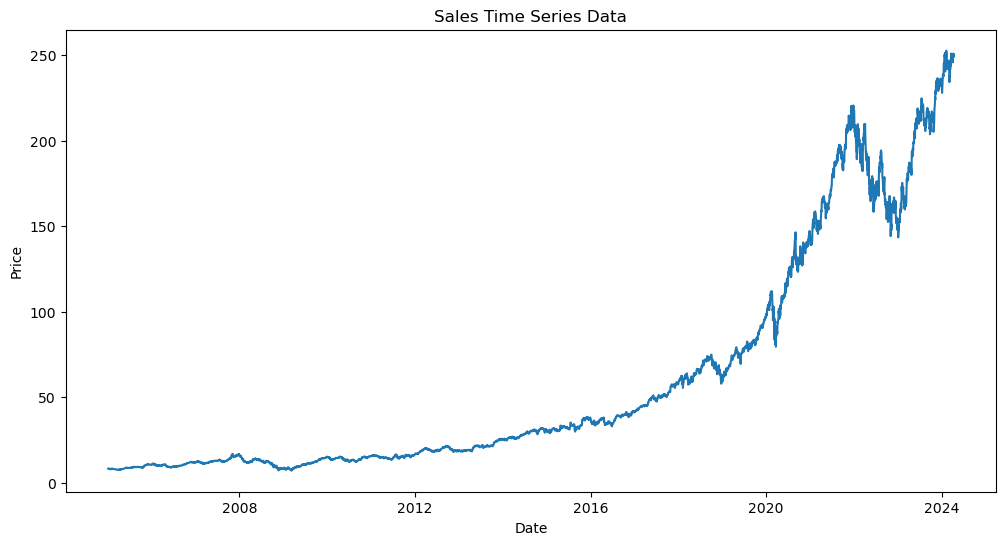

Checking mean and variance in different parts of data
Mean (First Half): 14.7156383288685, Mean (Second Half): 105.27905133591484
Variance (First Half): 27.005799068034047, Variance (Second Half): 4577.811126754478
ADF Fuller Test for stationarity
ADF Statistic: 2.763423233964467
p-value: 1.0
Critical Values: {'1%': -3.431708270326938, '5%': -2.862140203590599, '10%': -2.5670894899611865}
Rolling mean original


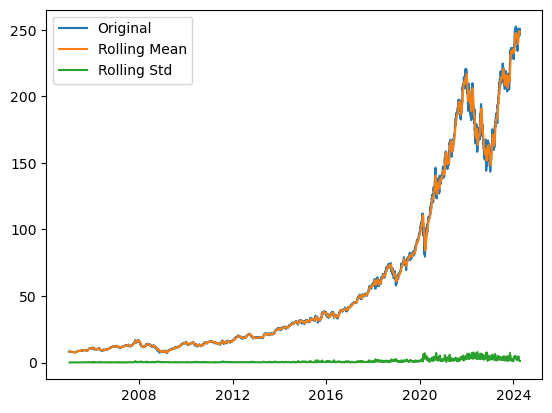


Rolling mean lag 1


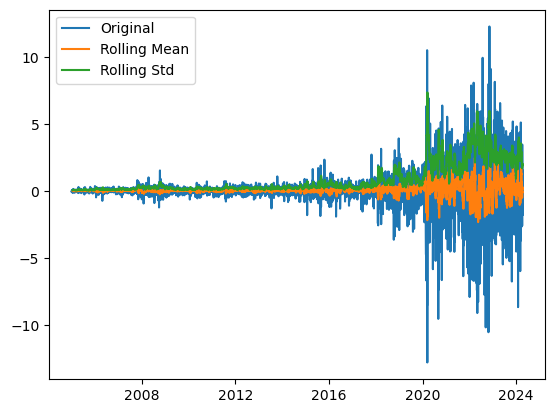


Rolling mean lag 1


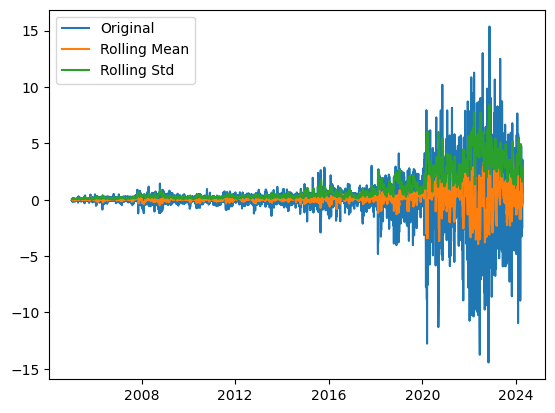


Rolling mean lag 1


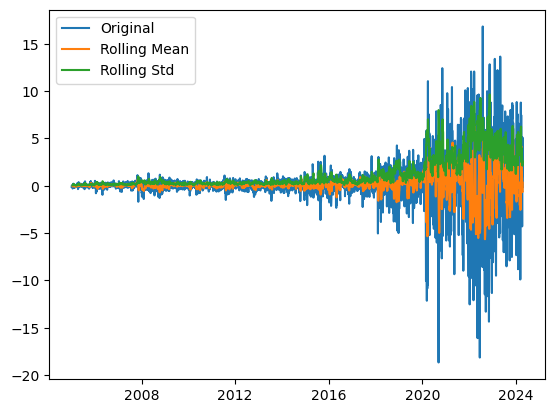


ACF and PACF


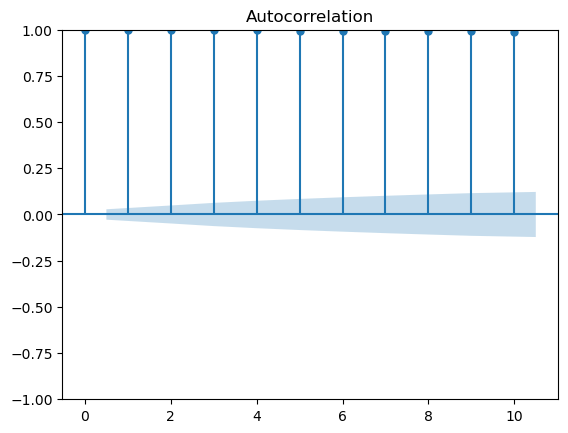

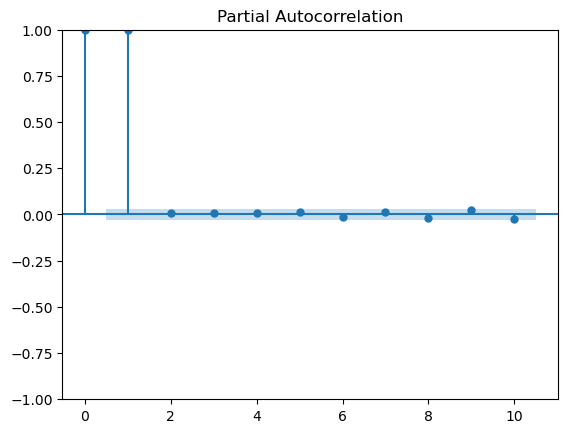

In [14]:
tech_df = grouped_df[grouped_df["Sector"] == "Technology"]
arima_model_preprocess(tech_df, "Adj Close")

In [15]:
target = "Adj Close"
series = tech_df[target]

split = int(0.90 * len(series))
train, test = series[0:split], series[split:len(series)]

In [16]:
# order (p, d, q), seasonal_order (P, D, Q, S)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  
model_fit = model.fit()

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62183D+00    |proj g|=  2.56913D-01

At iterate    5    f=  1.51256D+00    |proj g|=  4.01904D-02

At iterate   10    f=  1.49721D+00    |proj g|=  5.27896D-03

At iterate   15    f=  1.49641D+00    |proj g|=  9.16786D-04

At iterate   20    f=  1.49636D+00    |proj g|=  5.52660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   3.574D-06   1.496D+00
  F =   1.4963616222308669     

CONVERG

In [17]:
forecast = model_fit.forecast(steps=len(test))

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


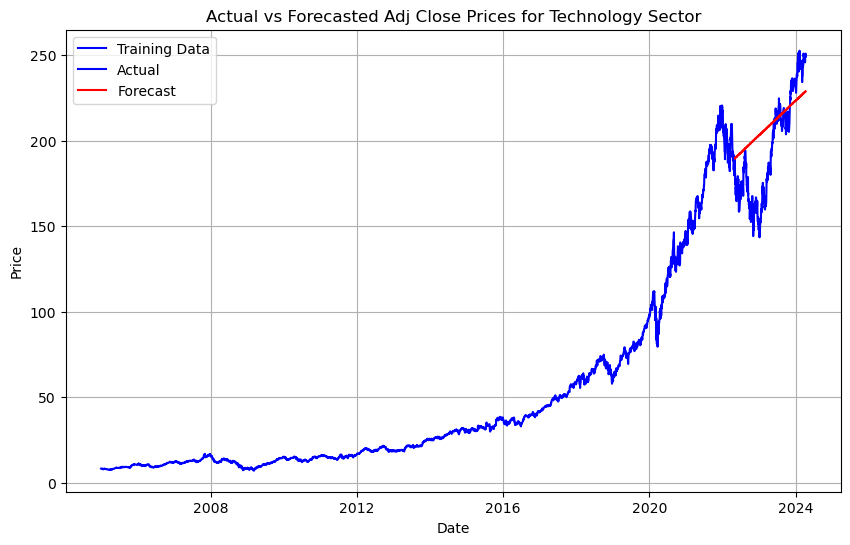

In [18]:
# Forecasted values for technology
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, color='blue', label='Training Data')
plt.plot(test.index, test, color='blue', label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('Actual vs Forecasted Adj Close Prices for Technology Sector')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

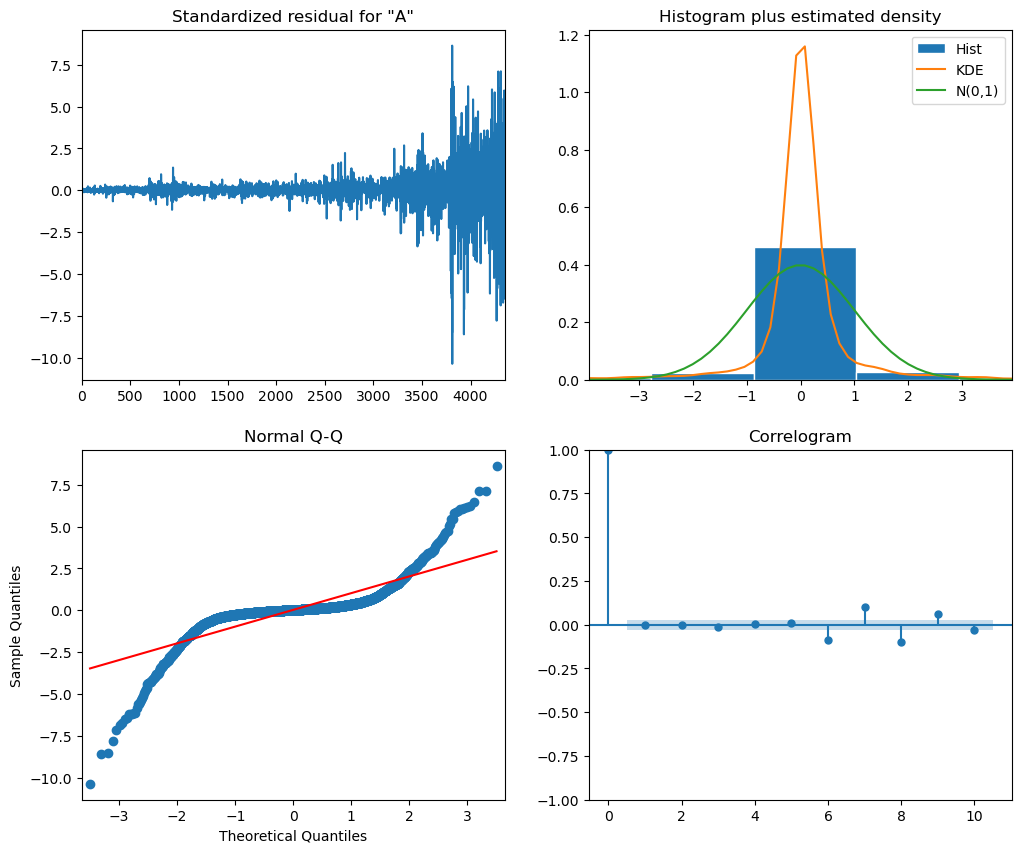

In [19]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

#### Finance

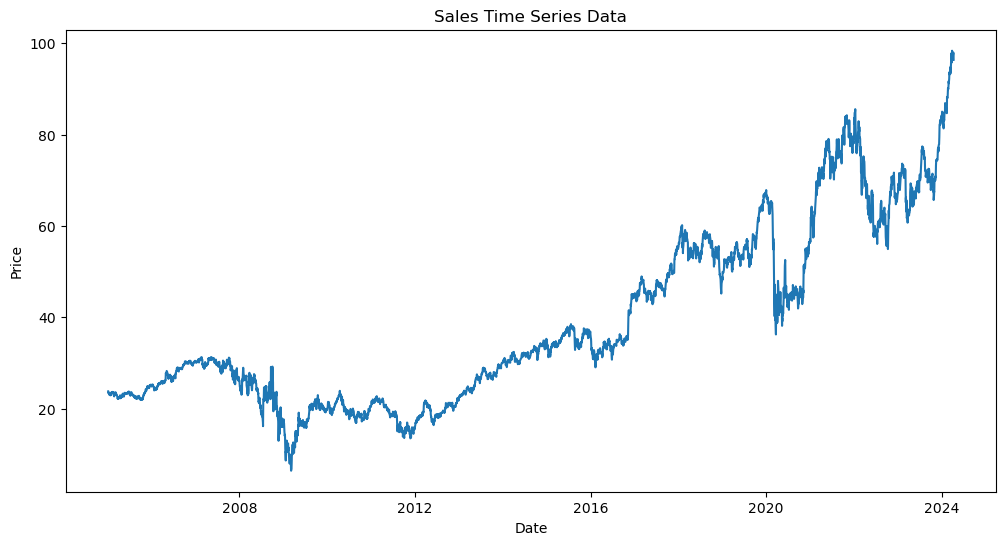

Checking mean and variance in different parts of data
Mean (First Half): 23.234812743327872, Mean (Second Half): 54.53924505620477
Variance (First Half): 26.025428492426016, Variance (Second Half): 245.66942011351475
ADF Fuller Test for stationarity
ADF Statistic: 0.4308222643369666
p-value: 0.9826117029958444
Critical Values: {'1%': -3.4317048932467036, '5%': -2.862138711638667, '10%': -2.56708869573285}
Rolling mean original


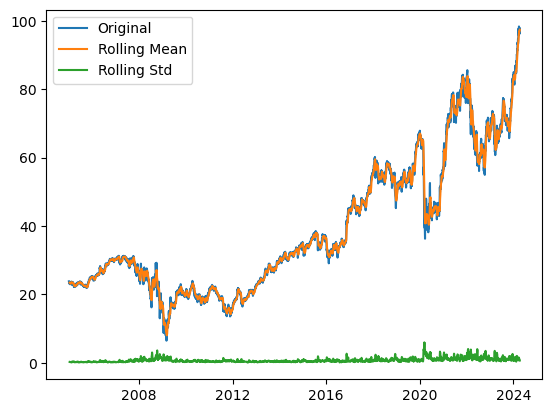


Rolling mean lag 1


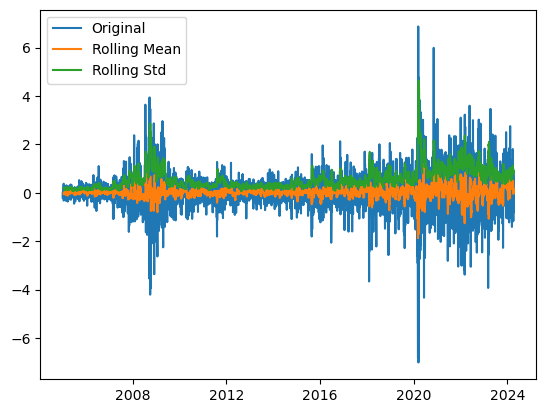


Rolling mean lag 1


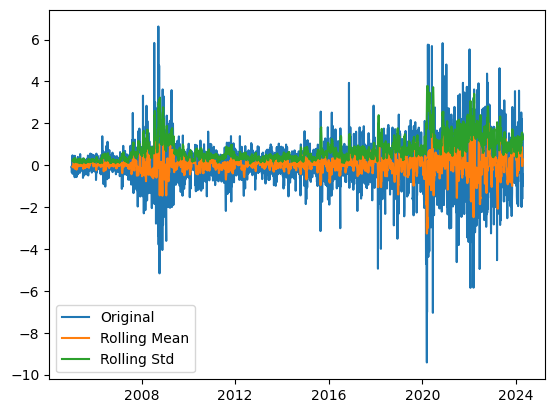


Rolling mean lag 1


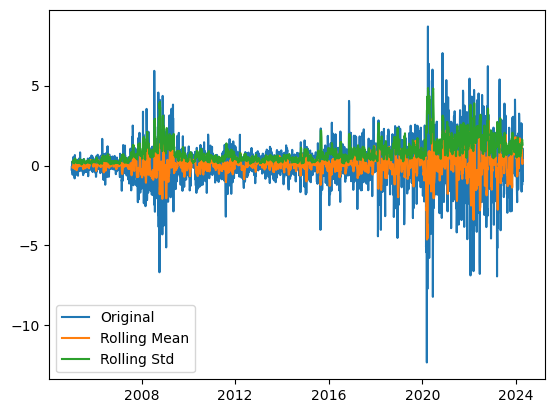


ACF and PACF


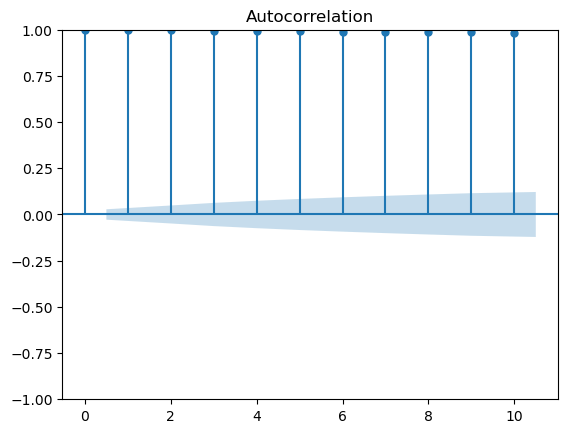

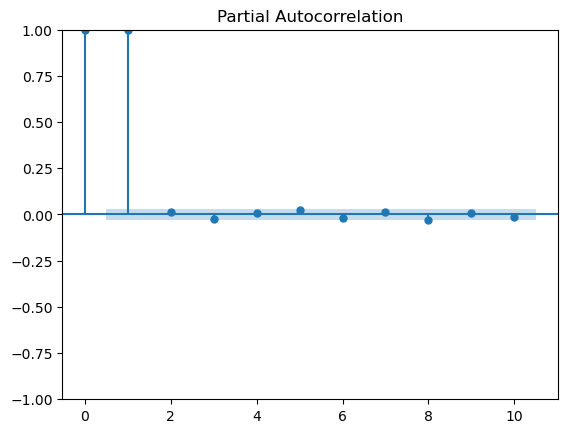

In [20]:
fin_df = grouped_df[grouped_df["Sector"] == "Finance"]
arima_model_preprocess(fin_df, "Adj Close")

In [21]:
target = "Adj Close"
series = fin_df[target]

split = int(0.90 * len(series))
train, test = series[0:split], series[split:len(series)]

In [22]:
# order (p, d, q), seasonal_order (P, D, Q, S)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19442D+00    |proj g|=  4.26949D-01


 This problem is unconstrained.



At iterate    5    f=  1.11440D+00    |proj g|=  6.34704D-02

At iterate   10    f=  1.07268D+00    |proj g|=  1.73120D-02

At iterate   15    f=  1.06749D+00    |proj g|=  3.37052D-03

At iterate   20    f=  1.06740D+00    |proj g|=  3.28134D-03

At iterate   25    f=  1.06739D+00    |proj g|=  2.72731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   4.255D-06   1.067D+00
  F =   1.0673949608645759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


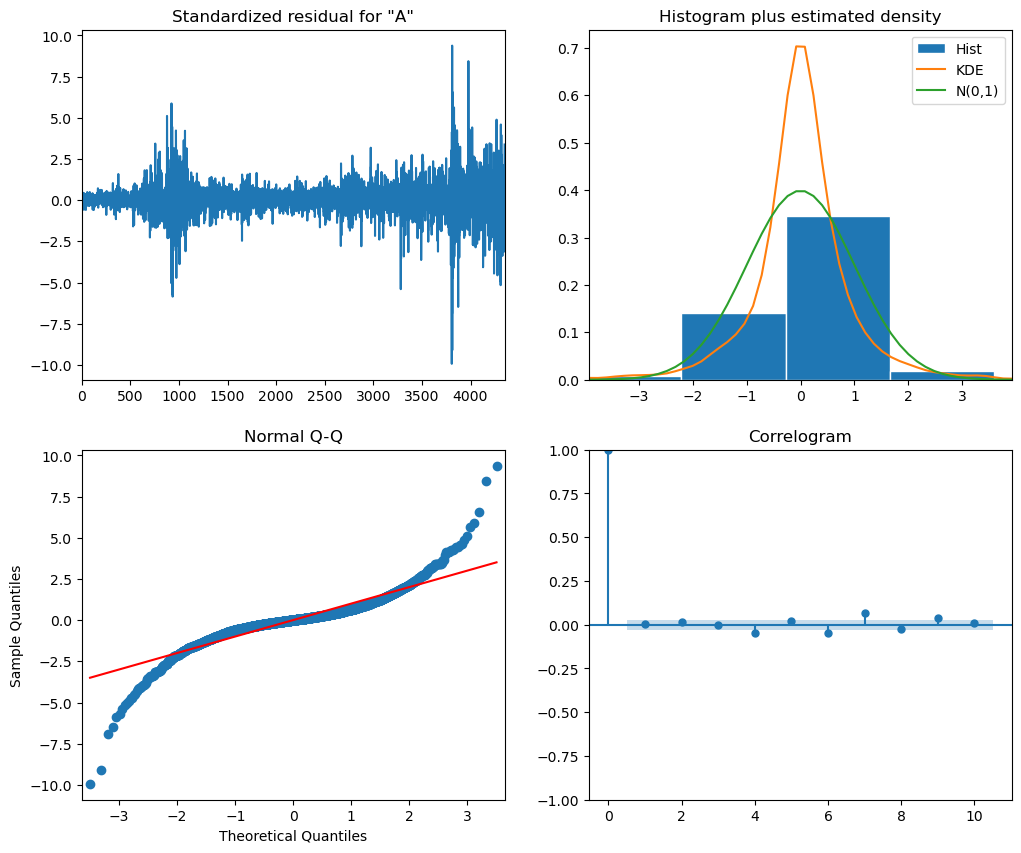

In [23]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

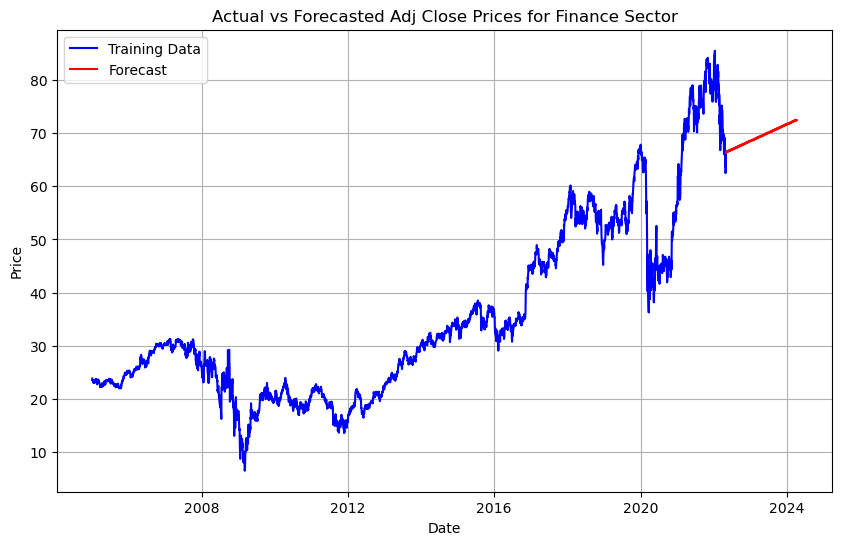

In [24]:
# Forecasted values for finance
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, color='blue', label='Training Data')
# plt.plot(test.index, test, color='blue', label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('Actual vs Forecasted Adj Close Prices for Finance Sector')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

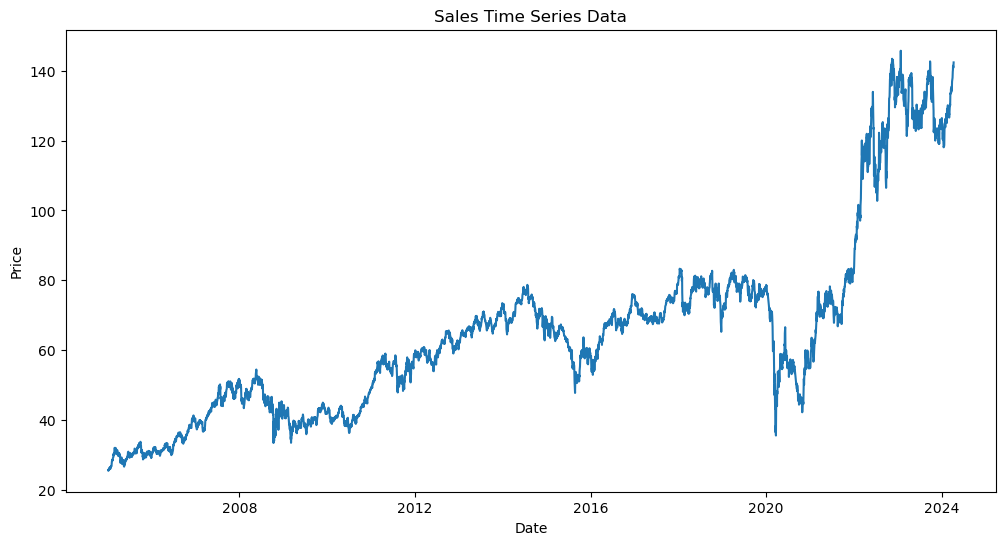

Checking mean and variance in different parts of data
Mean (First Half): 48.15100659911165, Mean (Second Half): 81.96019383538629
Variance (First Half): 173.77288891195843, Variance (Second Half): 654.6810865080759
ADF Fuller Test for stationarity
ADF Statistic: 0.22381836819822026
p-value: 0.9735662954921863
Critical Values: {'1%': -3.4317079882607233, '5%': -2.862140078977328, '10%': -2.5670894236243256}
Rolling mean original


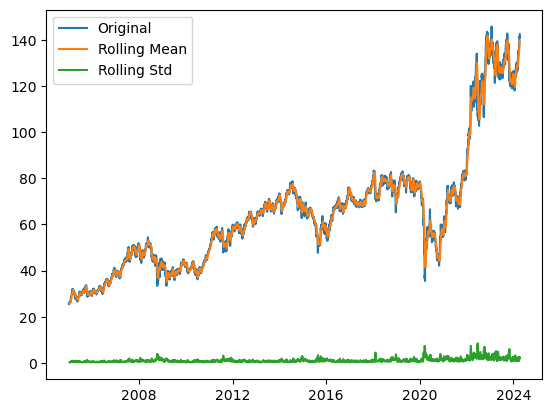


Rolling mean lag 1


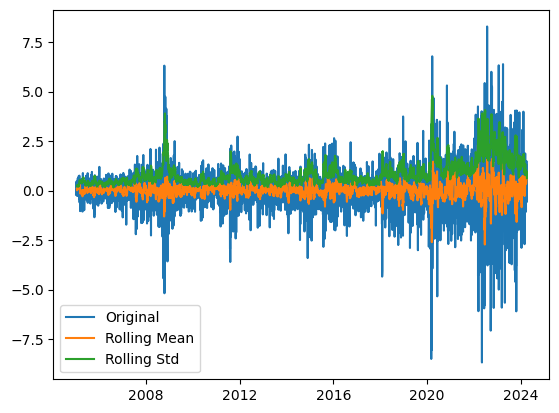


Rolling mean lag 1


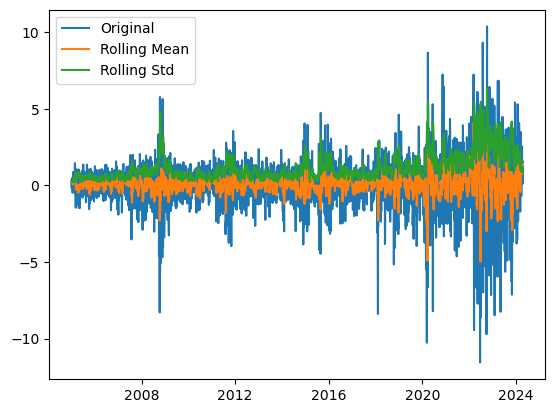


Rolling mean lag 1


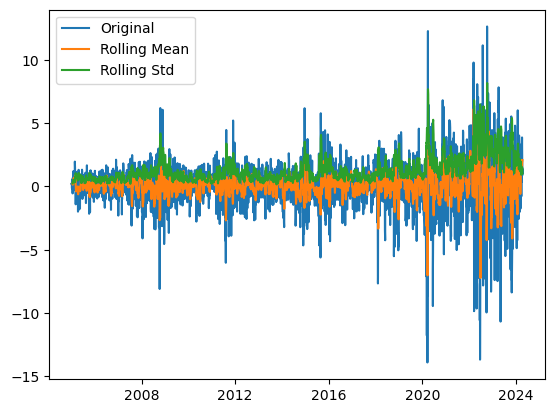


ACF and PACF


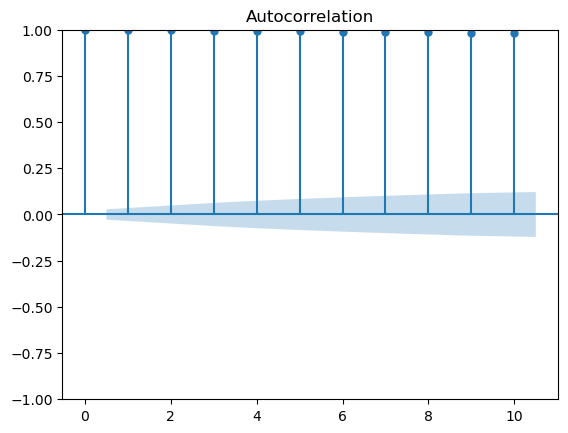

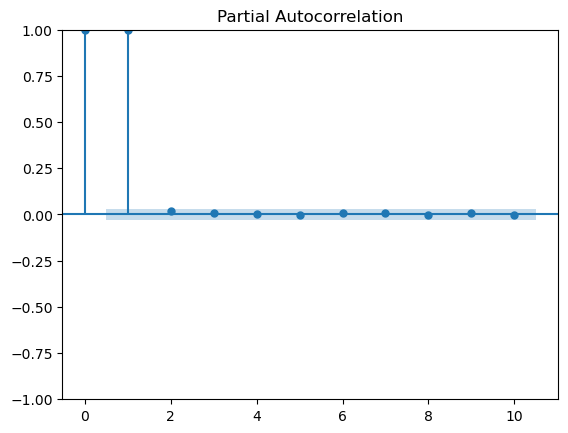

In [25]:
energy_df = grouped_df[grouped_df["Sector"] == "Energy"]
arima_model_preprocess(energy_df, "Adj Close")

In [26]:
target = "Adj Close"
series = fin_df[target]

split = int(0.90 * len(series))
train, test = series[0:split], series[split:len(series)]

In [27]:
# order (p, d, q), seasonal_order (P, D, Q, S)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19442D+00    |proj g|=  4.26949D-01

At iterate    5    f=  1.11440D+00    |proj g|=  6.34704D-02

At iterate   10    f=  1.07268D+00    |proj g|=  1.73120D-02

At iterate   15    f=  1.06749D+00    |proj g|=  3.37052D-03

At iterate   20    f=  1.06740D+00    |proj g|=  3.28134D-03

At iterate   25    f=  1.06739D+00    |proj g|=  2.72731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


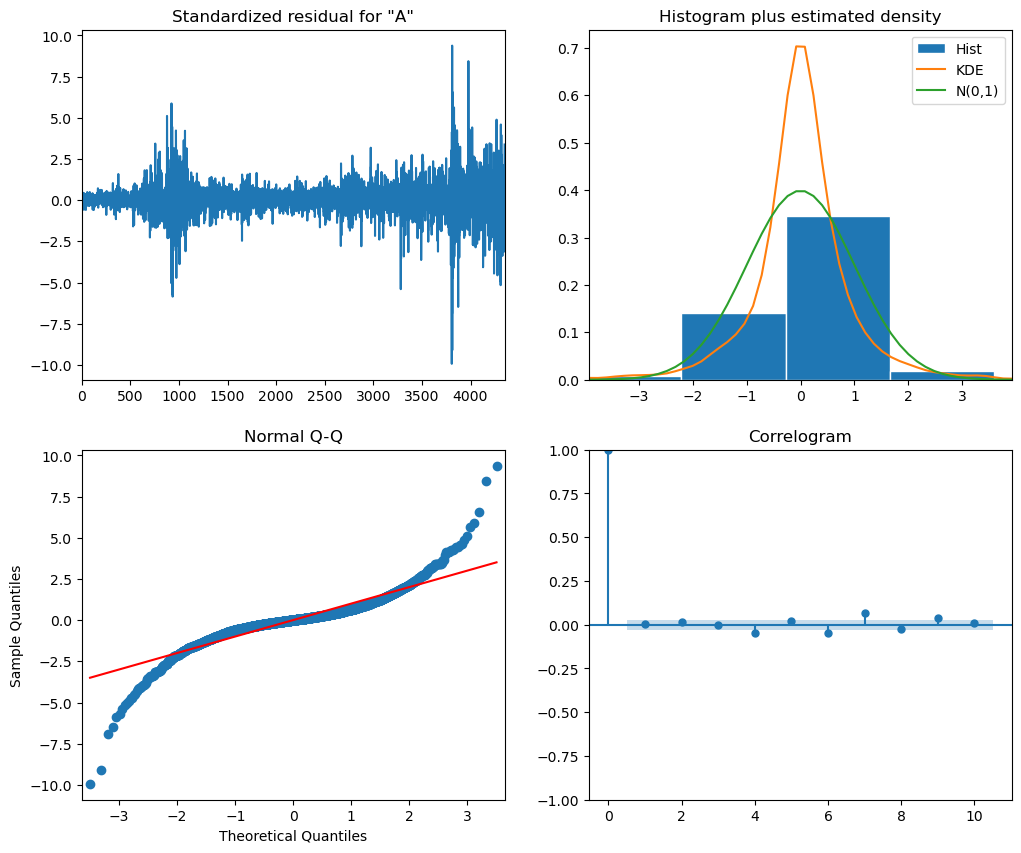

In [28]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

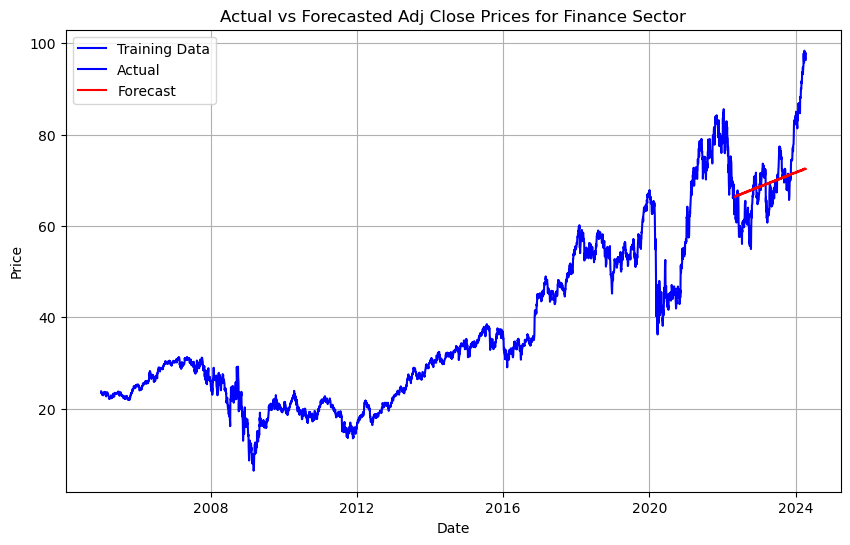

In [29]:
# Forecasted values for finance
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, color='blue', label='Training Data')
plt.plot(test.index, test, color='blue', label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('Actual vs Forecasted Adj Close Prices for Finance Sector')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## LSTM

Code in Colab https://colab.research.google.com/drive/1IoMolTGYoqzF5K156osAauCtoTWacKgh?usp=sharing